## 1. Importing datsets

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
full_dataset3 = pd.read_csv('datasets\\full_dataset_3.csv')

## 2. Balancing data

In [3]:
def plot_count(count):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    count0 = counter[0]
    count1 = counter[1]
    total = count0 + count1
    amount = (count0/total, count1/total)

    ax.barh([0,1], amount, align='center')
    ax.set_yticks([0,1])
    ax.set_yticklabels([0,1])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('% of data')
    ax.set_ylabel('Hate detection')
    ax.set_title('Data distribution')
    
    a = round(amount[0], 3)
    ax.text(a, 0, str(a*100) + '%', color='black')
    b = round(amount[1], 3)
    ax.text(b, 1, str(b*100) + '%', color='black')

    plt.xlim([0.0, 1.0])
    plt.show()

In [4]:
counter = Counter(full_dataset3['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 1430


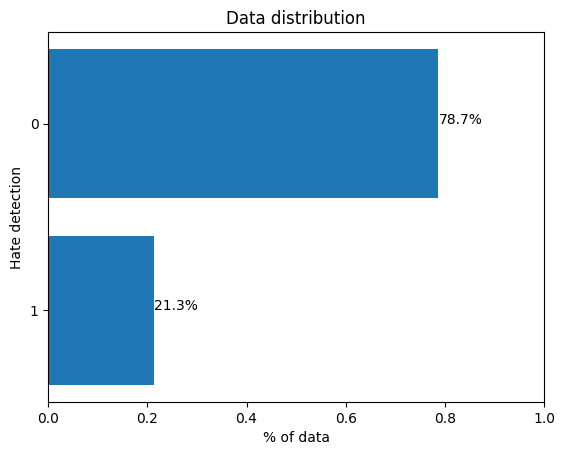

In [5]:
plot_count(counter)

In [6]:
full_dataset3_unbalanced = full_dataset3.copy()

### 2.1 Balancing through translation (oversampling)
The idea here is to translate to a random language and then back to portuguese. This will add random changes to the smaller class.

In [7]:
from textblob import TextBlob
from textblob.translate import NotTranslated
import random
from tqdm import tqdm
import time

from collections import Counter

from pandas import DataFrame
from sklearn.utils import shuffle

In [8]:
language = ["fr", "la", "es", "de", "it", "en", "ru", "zh", "fi"]

sr = random.SystemRandom()
def data_augmentation_translate(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    aug_range = abs(count0.text - count1.text)
    
    list_messages = dataframe[dataframe.hate_speech==class_values[1]]['text'].tolist()
    
    len_list = len(list_messages)
    augmented_messages = []

    for j in tqdm(range(0, aug_range)):
        ind = random.randint(0, len_list)
        message = list_messages[ind-1]
        
        if hasattr(message, "decode"):
            message = message.decode("utf-8")
        
        text = TextBlob(message)
        try:
            text = text.translate(to=sr.choice(language))   ## Converting to random langauge for meaningful variation
            time.sleep(2)
            text = text.translate(to="pt")
        except NotTranslated:
            pass
        augmented_messages.append([str(text), 1])

    df = DataFrame(augmented_messages)
    df.columns = ['text', 'hate_speech']
    
    data = pd.concat([dataframe, df])

    return shuffle(data)

In [9]:
try:
    full_dataset3_balanced_translate = pd.read_csv('datasets\\full_dataset3_balanced_translate.csv')
except FileNotFoundError:
    full_dataset3_balanced_translate = data_augmentation_translate(full_dataset3_unbalanced)
    full_dataset3_balanced_translate.to_csv('datasets\\full_dataset3_balanced_translate.csv', index=False)

In [10]:
counter = Counter(full_dataset3_balanced_translate['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 5271


### 2.2 Balancing through repetition (oversampling)
Now, we will just repeat some elements of the smaller class. This can generate some problems, such as skew the project.

In [11]:
def data_augmentation_repeating(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    aug_range = abs(count0.text - count1.text)
    
    list_messages = dataframe[dataframe.hate_speech==class_values[1]]['text'].tolist()
    
    len_list = len(list_messages)
    augmented_messages = []

    for j in range(aug_range):
        ind = random.randint(0, len_list)
        message = list_messages[ind-1]
        
        augmented_messages.append([message, 1])

    df = DataFrame(augmented_messages)
    df.columns = ['text', 'hate_speech']
    
    data = pd.concat([dataframe, df])

    return shuffle(data)

In [12]:
full_dataset3_balanced_repeating = data_augmentation_repeating(full_dataset3_unbalanced)

In [13]:
counter = Counter(full_dataset3_balanced_repeating['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 5271, Class 1: 5271


### 2.3 Balancing through removing random elements (undersampling)

In [14]:
def undersampling(dataframe, class_values=[0,1]):
    count0 = dataframe[dataframe.hate_speech==class_values[0]].count()
    count1 = dataframe[dataframe.hate_speech==class_values[1]].count()
    
    df1 = dataframe[dataframe.hate_speech==class_values[1]]
    
    diff = abs(count0.text - count1.text)
    list_messages = dataframe[dataframe.hate_speech==class_values[0]]['text'].tolist()

    for j in range(diff):
        ind = random.randint(0, len(list_messages))
        del list_messages[ind-1]

    df = DataFrame({'text':list_messages, 'hate_speech': np.repeat(0, len(list_messages))})
    
    data = pd.concat([df1, df])

    return shuffle(data)

In [15]:
full_dataset3_balanced_undersampling = undersampling(full_dataset3_unbalanced)

In [16]:
counter = Counter(full_dataset3_balanced_undersampling['hate_speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 1430, Class 1: 1430


## 3. Preprocessing data

In [17]:
import nltk
#nltk.download('stopwords')
#nltk.download('rslp')
from unidecode import unidecode
stem = nltk.stem.RSLPStemmer()

In [18]:
stopwords = set(nltk.corpus.stopwords.words('portuguese')) # get stop words in portuguese

def remove_stopwords(text):
    text_without_stopwords = [word for word in text.split() if word not in stopwords]
    # some elements of the dataset were only stopwords (eg: "quando foi isso")
    # if it's the case, we'll return the same text
    if text_without_stopwords == []:
        return text
    return ' '.join(text_without_stopwords)

def cleaning_data(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'rt+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[\"!$%-*&’‘*+”“,-./\[\]<=>\'?():;^_`<>{|}~#@]', '', text)
    return text

def stemming(text):
    text = text.split()
    new_text = []
    for word in text:
        new_text.append(stem.stem(word))
    return ' '.join(new_text)

def preprocessing1(text):
    text = cleaning_data(text)
    text = remove_stopwords(text)
    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    return text.split()

def preprocessing2(text):
    text = cleaning_data(text)
    text = remove_stopwords(text)
    text = stemming(text)
    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    return text.split()


In [19]:
f = open("datasets\\lista-palavroes-bloqueio.txt", "r", encoding="utf8")
list_bad_words = f.readlines()
list_bad_words = [x.strip() for x in list_bad_words]
f.close()

def tagging_swearwords(text):
    text = [word if (word.upper() not in list_bad_words) else "_SWEARWORD" for word in text.split()]
    text = ' '.join(text)
    return text

def tagging_laughs(text):
    return re.sub(r'k{2,}|a*ha+h[ha]*|e*he+h[he]*|s*rs+r[rs]*', '_LAUGHS ', text)

def preprocessing3(text):
    text = cleaning_data(text)
    text = remove_stopwords(text)
    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    text = tagging_swearwords(text)
    text = tagging_laughs(text)
    return text.split()

def preprocessing4(text):
    text = cleaning_data(text)
    text = remove_stopwords(text)
    text = stemming(text)
    text = unidecode(text) #remove accents (e.g.: á, ã, à will be "a")
    text = tagging_swearwords(text)
    text = tagging_laughs(text)
    return text.split()

## 4. Feature extraction

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### 4.1 Bag of Words (BoW): CountVectorizer

In [21]:
full_dataset3_balanced_undersampling

,text,hate_speech
353,"""Provocador de extrema direita.""\r\nJá defende...",0
1283,'O Sr Temer foi posto la por vcs que votaram...,0
530,@Publico \r\nHaja administrações com juízo! Fi...,0
1379,'e tome dinheiro pra industria da seca',0
6439,'Ele vai sentir o peru entrar',1
...,...,...
546,"Lligação prum gordo: ""E AE GORDO, BORA ALMOÇA?...",1
2946,Trump diz que refugiados devem voltar a seus p...,1
3838,@edmilsonpapo10 @elpais_brasil \r\nSegundo os ...,1
790,RT @blogdojefferson: Marcelo disse que se reun...,0


In [22]:
bow_transformer1 = CountVectorizer(analyzer=preprocessing1).fit_transform(full_dataset3_balanced_translate['text'])
bow_transformer1

<10542x16050 sparse matrix of type '<class 'numpy.int64'>'
	with 85360 stored elements in Compressed Sparse Row format>

In [23]:
bow_transformer2 = CountVectorizer(analyzer=preprocessing2).fit_transform(full_dataset3_balanced_translate['text'])
bow_transformer2

<10542x9367 sparse matrix of type '<class 'numpy.int64'>'
	with 84736 stored elements in Compressed Sparse Row format>

In [24]:
bow_transformer3 = CountVectorizer(analyzer=preprocessing3).fit_transform(full_dataset3_balanced_translate['text'])
bow_transformer3

<10542x15871 sparse matrix of type '<class 'numpy.int64'>'
	with 85096 stored elements in Compressed Sparse Row format>

In [25]:
bow_transformer4 = CountVectorizer(analyzer=preprocessing4).fit_transform(full_dataset3_balanced_translate['text'])
bow_transformer4

<10542x9286 sparse matrix of type '<class 'numpy.int64'>'
	with 84766 stored elements in Compressed Sparse Row format>

In [26]:
print(bow_transformer4)

  (0, 6164)	1
  (0, 5901)	1
  (0, 3858)	1
  (0, 6962)	1
  (0, 5720)	1
  (1, 5649)	1
  (1, 4489)	1
  (1, 3541)	1
  (1, 7280)	1
  (1, 2754)	1
  (2, 7672)	1
  (2, 7135)	1
  (2, 7304)	1
  (2, 2266)	1
  (3, 5720)	1
  (3, 3479)	1
  (3, 3181)	1
  (3, 8620)	1
  (3, 3648)	1
  (3, 8153)	1
  (3, 1808)	1
  (3, 8756)	1
  (3, 3140)	1
  (3, 499)	1
  (3, 240)	1
  :	:
  (10537, 4299)	1
  (10537, 337)	1
  (10537, 7380)	1
  (10537, 1096)	1
  (10537, 2482)	1
  (10537, 7925)	1
  (10538, 7984)	1
  (10538, 4755)	1
  (10538, 2905)	1
  (10538, 5292)	1
  (10538, 3815)	1
  (10539, 5609)	2
  (10539, 4881)	1
  (10539, 5104)	1
  (10539, 9132)	1
  (10539, 7721)	1
  (10539, 6185)	1
  (10540, 6962)	1
  (10540, 2604)	1
  (10540, 8966)	1
  (10540, 5632)	1
  (10541, 7770)	1
  (10541, 3597)	1
  (10541, 8580)	1
  (10541, 1858)	1


### 4.2 TF-IDF

In [27]:
tfidf = TfidfTransformer().fit_transform(bow_transformer4)

In [28]:
print(tfidf)

  (0, 6962)	0.30004813165575506
  (0, 6164)	0.6557335989622357
  (0, 5901)	0.3745063143395876
  (0, 5720)	0.4371912047816348
  (0, 3858)	0.3854781924613701
  (1, 7280)	0.49998582611669684
  (1, 5649)	0.4363237491968151
  (1, 4489)	0.4469320934403198
  (1, 3541)	0.29706672972883935
  (1, 2754)	0.5211898133218885
  (2, 7672)	0.6044844820983668
  (2, 7304)	0.40301259762088465
  (2, 7135)	0.5290626739337252
  (2, 2266)	0.43848836257218166
  (3, 8756)	0.225077747460486
  (3, 8620)	0.29216982627930227
  (3, 8153)	0.22213686431125212
  (3, 5720)	0.24906358742537707
  (3, 4713)	0.3162707117155398
  (3, 3769)	0.3429994241505008
  (3, 3648)	0.4041307137234373
  (3, 3479)	0.18416819277455512
  (3, 3181)	0.28095888784604056
  (3, 3140)	0.26987669958936594
  (3, 1808)	0.3124337793640325
  :	:
  (10537, 7380)	0.287622379463691
  (10537, 5888)	0.5033130939668834
  (10537, 4299)	0.2287507458997168
  (10537, 2482)	0.3635454544185731
  (10537, 1096)	0.3118793049400202
  (10537, 337)	0.35837836545824586


## 5. Machine learning!

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [30]:
# unbalanced
text3_unb = full_dataset3_unbalanced['text']
class3_unb = full_dataset3_unbalanced['hate_speech']

# balanced translated
text3_tra = full_dataset3_balanced_translate['text']
class3_tra = full_dataset3_balanced_translate['hate_speech']

# balanced repeating
text3_rep = full_dataset3_balanced_repeating['text']
class3_rep = full_dataset3_balanced_repeating['hate_speech']

# balanced undersampling
text3_und = full_dataset3_balanced_undersampling['text']
class3_und = full_dataset3_balanced_undersampling['hate_speech']


### 5.1 Splitting the data: train, test and validation

In [31]:
# data = [x_train, x_test, y_train, y_test]

X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(text3_unb, class3_unb, test_size=0.2, random_state=1)
X_train_unb, X_val_unb, y_train_unb, y_val_unb = train_test_split(X_train_unb, y_train_unb, test_size=0.25, random_state=1)

X_train_tra, X_test_tra, y_train_tra, y_test_tra = train_test_split(text3_tra, class3_tra, test_size=0.2, random_state=1)
X_train_tra, X_val_tra, y_train_tra, y_val_tra = train_test_split(X_train_tra, y_train_tra, test_size=0.25, random_state=1)

X_train_rep, X_test_rep, y_train_rep, y_test_rep = train_test_split(text3_rep, class3_rep, test_size=0.2, random_state=1)
X_train_rep, X_val_rep, y_train_rep, y_val_rep = train_test_split(X_train_rep, y_train_rep, test_size=0.25, random_state=1)

X_train_und, X_test_und, y_train_und, y_test_und = train_test_split(text3_und, class3_und, test_size=0.2, random_state=1)
X_train_und, X_val_und, y_train_und, y_val_und = train_test_split(X_train_und, y_train_und, test_size=0.25, random_state=1)


In [32]:
# arrays to save results
f1_val = np.zeros((12, 8))
f1_test = np.zeros((12, 8))

In [33]:
def predict_test(X, y, pipeline):
    result = pipeline.predict(X)
    print(confusion_matrix(y, result))
    return f1_score(y, result, average='weighted')

### 5.2 ML models

#### 5.2.1 RandomForestClassifier

In [34]:
max_depth_values = range(1, 11)
def random_forest_eval(data):
    best = None
    diff = 1
    train_scores = []
    val_scores = []
    for i in max_depth_values:
        clf = RandomForestClassifier(max_depth=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing4, ngram_range=(1,1))),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_accuracy = f1_score(data[2], train_predict, average='weighted')
        train_scores.append(train_accuracy)
        
        val_predict = pipeline.predict(data[1])
        val_accuracy = f1_score(data[3], val_predict, average='weighted')
        val_scores.append(val_accuracy)  

    return [train_scores, val_scores]


In [35]:
scores_data3_unbalanced = random_forest_eval([X_train_unb, X_val_unb, y_train_unb, y_val_unb])
scores_data3_balanced_translate = random_forest_eval([X_train_tra, X_val_tra, y_train_tra, y_val_tra])
scores_data3_balanced_repeating = random_forest_eval([X_train_rep, X_val_rep, y_train_rep, y_val_rep])
scores_data3_balanced_undersampl = random_forest_eval([X_train_und, X_val_und, y_train_und, y_val_und])

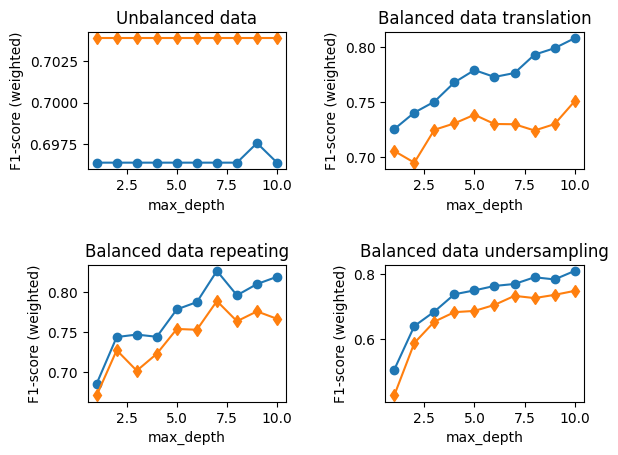

In [36]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(max_depth_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(max_depth_values, scores_data3_unbalanced[1], '-d', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(max_depth_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(max_depth_values, scores_data3_balanced_translate[1], '-d', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(max_depth_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(max_depth_values, scores_data3_balanced_repeating[1], '-d', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(max_depth_values, scores_data3_balanced_undersampl[0], '-o', label='Train')
axs[1, 1].plot(max_depth_values, scores_data3_balanced_undersampl[1], '-d', label='Test')
axs[1, 1].set_title('Balanced data undersampling')

for ax in axs.flat:
    ax.set(xlabel='max_depth', ylabel='F1-score (weighted)')

plt.subplots_adjust(hspace=0.7, wspace = 0.5)

plt.show()

In [37]:
rfc = RandomForestClassifier(max_depth=5) # max_depth chosen based on graph above

def random_forest(X_train, X_val, y_train, y_val, preproc):
    rfc_bow = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('classifier', rfc),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])

    rfc_bow.fit(X_train, y_train)
    result_val1 = rfc_bow.predict(X_val)
    print('BOW')
    print(confusion_matrix(y_val, result_val1))
    f1_bow = f1_score(y_val, result_val1, average='weighted')
    
    rfc_tfidf = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', rfc),
    ])
    
    rfc_tfidf.fit(X_train, y_train)
    result_val2 = rfc_tfidf.predict(X_val)
    print('TF-IDF')
    print(confusion_matrix(y_val, result_val2))
    f1_tfidf = f1_score(y_val, result_val2, average='weighted')
    
    return f1_bow, f1_tfidf, rfc_bow, rfc_tfidf
    

In [38]:
print('UNBALANCED')
f1_val[0][0], f1_val[0][1], rfc_bow_unb1, rfc_tfidf_unb1 = random_forest(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing1)
f1_test[0][0] = predict_test(X_test_unb, y_test_unb, rfc_bow_unb1)
f1_test[0][1] = predict_test(X_test_unb, y_test_unb, rfc_tfidf_unb1)

f1_val[3][0], f1_val[3][1], rfc_bow_unb2, rfc_tfidf_unb2 = random_forest(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing2)
f1_test[3][0] = predict_test(X_test_unb, y_test_unb, rfc_bow_unb2)
f1_test[3][1] = predict_test(X_test_unb, y_test_unb, rfc_tfidf_unb2)

f1_val[6][0], f1_val[6][1], rfc_bow_unb3, rfc_tfidf_unb3 = random_forest(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing3)
f1_test[6][0] = predict_test(X_test_unb, y_test_unb, rfc_bow_unb3)
f1_test[6][1] = predict_test(X_test_unb, y_test_unb, rfc_tfidf_unb3)

f1_val[9][0], f1_val[9][1], rfc_bow_unb4, rfc_tfidf_unb4 = random_forest(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing4)
f1_test[9][0] = predict_test(X_test_unb, y_test_unb, rfc_bow_unb4)
f1_test[9][1] = predict_test(X_test_unb, y_test_unb, rfc_tfidf_unb4)


print('UNDERSAMPLING')
f1_val[0][2], f1_val[0][3], rfc_bow_und1, rfc_tfidf_und1 = random_forest(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing1)
f1_test[0][2] = predict_test(X_test_und, y_test_und, rfc_bow_und1)
f1_test[0][3] = predict_test(X_test_und, y_test_und, rfc_tfidf_und1)

f1_val[3][2], f1_val[3][3], rfc_bow_und2, rfc_tfidf_und2 = random_forest(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing2)
f1_test[3][2] = predict_test(X_test_und, y_test_und, rfc_bow_und2)
f1_test[3][3] = predict_test(X_test_und, y_test_und, rfc_tfidf_und2)

f1_val[6][2], f1_val[6][3], rfc_bow_und3, rfc_tfidf_und3 = random_forest(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing3)
f1_test[6][2] = predict_test(X_test_und, y_test_und, rfc_bow_und3)
f1_test[6][3] = predict_test(X_test_und, y_test_und, rfc_tfidf_und3)

f1_val[9][2], f1_val[9][3], rfc_bow_und4, rfc_tfidf_und4 = random_forest(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing4)
f1_test[9][2] = predict_test(X_test_und, y_test_und, rfc_bow_und4)
f1_test[9][3] = predict_test(X_test_und, y_test_und, rfc_tfidf_und4)


print('REPEATING')
f1_val[0][4], f1_val[0][5], rfc_bow_rep1, rfc_tfidf_rep1 = random_forest(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing1)
f1_test[0][4] = predict_test(X_test_rep, y_test_rep, rfc_bow_rep1)
f1_test[0][5] = predict_test(X_test_rep, y_test_rep, rfc_tfidf_rep1)

f1_val[3][4], f1_val[3][5], rfc_bow_rep2, rfc_tfidf_rep2 = random_forest(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing2)
f1_test[3][4] = predict_test(X_test_rep, y_test_rep, rfc_bow_rep2)
f1_test[3][5] = predict_test(X_test_rep, y_test_rep, rfc_tfidf_rep2)

f1_val[6][4], f1_val[6][5], rfc_bow_rep3, rfc_tfidf_rep3 = random_forest(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing3)
f1_test[6][4] = predict_test(X_test_rep, y_test_rep, rfc_bow_rep3)
f1_test[6][5] = predict_test(X_test_rep, y_test_rep, rfc_tfidf_rep3)

f1_val[9][4], f1_val[9][5], rfc_bow_rep4, rfc_tfidf_rep4 = random_forest(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing4)
f1_test[9][4] = predict_test(X_test_rep, y_test_rep, rfc_bow_rep4)
f1_test[9][5] = predict_test(X_test_rep, y_test_rep, rfc_tfidf_rep4)

print('TRANSLATION')
f1_val[0][6], f1_val[0][7], rfc_bow_tra1, rfc_tfidf_tra1 = random_forest(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing1)
f1_test[0][6] = predict_test(X_test_tra, y_test_tra, rfc_bow_tra1)
f1_test[0][7] = predict_test(X_test_tra, y_test_tra, rfc_tfidf_tra1)

f1_val[3][6], f1_val[3][7], rfc_bow_tra2, rfc_tfidf_tra2 = random_forest(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing2)
f1_test[3][6] = predict_test(X_test_tra, y_test_tra, rfc_bow_tra2)
f1_test[3][7] = predict_test(X_test_tra, y_test_tra, rfc_tfidf_tra2)

f1_val[6][6], f1_val[6][7], rfc_bow_tra3, rfc_tfidf_tra3 = random_forest(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing3)
f1_test[6][6] = predict_test(X_test_tra, y_test_tra, rfc_bow_tra3)
f1_test[6][7] = predict_test(X_test_tra, y_test_tra, rfc_tfidf_tra3)

f1_val[9][6], f1_val[9][7], rfc_bow_tra4, rfc_tfidf_tra4 = random_forest(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing4)
f1_test[9][6] = predict_test(X_test_tra, y_test_tra, rfc_bow_tra4)
f1_test[9][7] = predict_test(X_test_tra, y_test_tra, rfc_tfidf_tra4)


UNBALANCED
BOW
[[1065    0]
 [ 275    0]]
TF-IDF
[[1065    0]
 [ 275    0]]
[[1033    0]
 [ 308    0]]
[[1033    0]
 [ 308    0]]
BOW
[[1065    0]
 [ 275    0]]
TF-IDF
[[1065    0]
 [ 275    0]]
[[1033    0]
 [ 308    0]]
[[1033    0]
 [ 308    0]]
BOW
[[1065    0]
 [ 275    0]]
TF-IDF
[[1065    0]
 [ 275    0]]
[[1033    0]
 [ 308    0]]
[[1033    0]
 [ 308    0]]
BOW
[[1065    0]
 [ 275    0]]
TF-IDF
[[1065    0]
 [ 275    0]]
[[1033    0]
 [ 308    0]]
[[1033    0]
 [ 308    0]]
UNDERSAMPLING
BOW
[[255   7]
 [150 160]]
TF-IDF
[[252  10]
 [155 155]]
[[259  28]
 [138 147]]
[[266  21]
 [150 135]]
BOW
[[253   9]
 [172 138]]
TF-IDF
[[251  11]
 [156 154]]
[[246  41]
 [141 144]]
[[260  27]
 [153 132]]
BOW
[[251  11]
 [182 128]]
TF-IDF
[[243  19]
 [154 156]]
[[255  32]
 [145 140]]
[[262  25]
 [153 132]]
BOW
[[254   8]
 [160 150]]
TF-IDF
[[243  19]
 [164 146]]
[[247  40]
 [141 144]]
[[260  27]
 [146 139]]
REPEATING
BOW
[[960  96]
 [449 604]]
TF-IDF
[[907 149]
 [405 648]]
[[862 183]
 [350 714

#### 5.2.2 MultinomialNB

In [39]:
alpha_values = range(1, 11)
def multinomial_nb_eval(data):
    train_scores = []
    val_scores = []
    for i in alpha_values:
        clf = MultinomialNB(alpha=i)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing4, ngram_range=(1,1))),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_f1 = f1_score(data[2], train_predict, average='weighted')
        train_scores.append(train_f1)
        
        val_predict = pipeline.predict(data[1])
        val_f1 = f1_score(data[3], val_predict, average='weighted')
        val_scores.append(val_f1)  
        
    return [train_scores, val_scores]

In [40]:
scores_data3_unbalanced = multinomial_nb_eval([X_train_unb, X_val_unb, y_train_unb, y_val_unb])
scores_data3_balanced_translate = multinomial_nb_eval([X_train_tra, X_val_tra, y_train_tra, y_val_tra])
scores_data3_balanced_repeating = multinomial_nb_eval([X_train_rep, X_val_rep, y_train_rep, y_val_rep])
scores_data3_balanced_undersampl = multinomial_nb_eval([X_train_und, X_val_und, y_train_und, y_val_und])

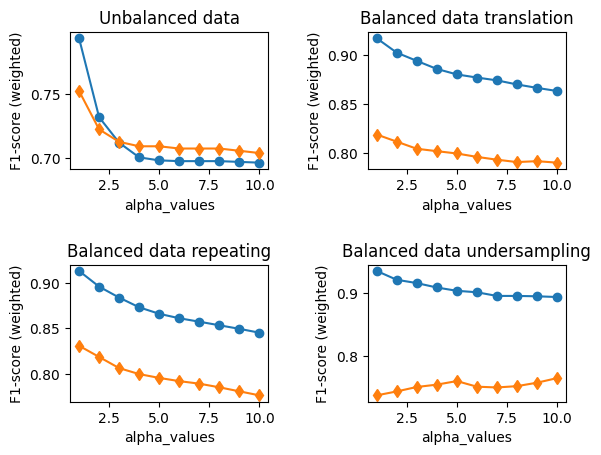

In [41]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(alpha_values, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(alpha_values, scores_data3_unbalanced[1], '-d', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(alpha_values, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(alpha_values, scores_data3_balanced_translate[1], '-d', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(alpha_values, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(alpha_values, scores_data3_balanced_repeating[1], '-d', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(alpha_values, scores_data3_balanced_undersampl[0], '-o', label='Train')
axs[1, 1].plot(alpha_values, scores_data3_balanced_undersampl[1], '-d', label='Test')
axs[1, 1].set_title('Balanced data undersampling')

for ax in axs.flat:
    ax.set(xlabel='alpha_values', ylabel='F1-score (weighted)')

plt.subplots_adjust(hspace=0.7, wspace = 0.5)

plt.show()

In [42]:
mnb = MultinomialNB(alpha=2) # alpha chosen based on graph above

def multinomial_nb(X_train, X_val, y_train, y_val, preproc):
    mnb_bow = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('classifier', mnb),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])

    mnb_bow.fit(X_train, y_train)
    result_val1 = mnb_bow.predict(X_val)
    print('BOW')
    print(confusion_matrix(y_val, result_val1))
    f1_bow = f1_score(y_val, result_val1, average='weighted')
    
    mnb_tfidf = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', mnb),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])
    
    mnb_tfidf.fit(X_train, y_train)
    result_val2 = mnb_tfidf.predict(X_val)
    print('TF-IDF')
    print(confusion_matrix(y_val, result_val2))
    f1_tfidf = f1_score(y_val, result_val2, average='weighted')
    
    return f1_bow, f1_tfidf, mnb_bow, mnb_tfidf

In [43]:
print('UNBALANCED')
f1_val[1][0], f1_val[1][1], mnb_bow_unb1, mnb_tfidf_unb1 = multinomial_nb(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing1)
f1_test[1][0] = predict_test(X_test_unb, y_test_unb, mnb_bow_unb1)
f1_test[1][1] = predict_test(X_test_unb, y_test_unb, mnb_tfidf_unb1)

f1_val[4][0], f1_val[4][1], mnb_bow_unb2, mnb_tfidf_unb2 = multinomial_nb(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing2)
f1_test[4][0] = predict_test(X_test_unb, y_test_unb, mnb_bow_unb2)
f1_test[4][1] = predict_test(X_test_unb, y_test_unb, mnb_tfidf_unb2)

f1_val[7][0], f1_val[7][1], mnb_bow_unb3, mnb_tfidf_unb3 = multinomial_nb(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing3)
f1_test[7][0] = predict_test(X_test_unb, y_test_unb, mnb_bow_unb3)
f1_test[7][1] = predict_test(X_test_unb, y_test_unb, mnb_tfidf_unb3)

f1_val[10][0], f1_val[10][1], mnb_bow_unb4, mnb_tfidf_unb4 = multinomial_nb(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing4)
f1_test[10][0] = predict_test(X_test_unb, y_test_unb, mnb_bow_unb4)
f1_test[10][1] = predict_test(X_test_unb, y_test_unb, mnb_tfidf_unb4)


print('UNDERSAMPLING')
f1_val[1][2], f1_val[1][3], mnb_bow_und1, mnb_tfidf_und1 = multinomial_nb(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing1)
f1_test[1][2] = predict_test(X_test_und, y_test_und, mnb_bow_und1)
f1_test[1][3] = predict_test(X_test_und, y_test_und, mnb_tfidf_und1)

f1_val[4][2], f1_val[4][3], mnb_bow_und2, mnb_tfidf_und2 = multinomial_nb(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing2)
f1_test[4][2] = predict_test(X_test_und, y_test_und, mnb_bow_und2)
f1_test[4][3] = predict_test(X_test_und, y_test_und, mnb_tfidf_und2)

f1_val[7][2], f1_val[7][3], mnb_bow_und3, mnb_tfidf_und3 = multinomial_nb(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing3)
f1_test[7][2] = predict_test(X_test_und, y_test_und, mnb_bow_und3)
f1_test[7][3] = predict_test(X_test_und, y_test_und, mnb_tfidf_und3)

f1_val[10][2], f1_val[10][3], mnb_bow_und4, mnb_tfidf_und4 = multinomial_nb(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing4)
f1_test[10][2] = predict_test(X_test_und, y_test_und, mnb_bow_und4)
f1_test[10][3] = predict_test(X_test_und, y_test_und, mnb_tfidf_und4)


print('REPEATING')
f1_val[1][4], f1_val[1][5], mnb_bow_rep1, mnb_tfidf_rep1 = multinomial_nb(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing1)
f1_test[1][4] = predict_test(X_test_rep, y_test_rep, mnb_bow_rep1)
f1_test[1][5] = predict_test(X_test_rep, y_test_rep, mnb_tfidf_rep1)

f1_val[4][4], f1_val[4][5], mnb_bow_rep2, mnb_tfidf_rep2 = multinomial_nb(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing2)
f1_test[4][4] = predict_test(X_test_rep, y_test_rep, mnb_bow_rep2)
f1_test[4][5] = predict_test(X_test_rep, y_test_rep, mnb_tfidf_rep2)

f1_val[7][4], f1_val[7][5], mnb_bow_rep3, mnb_tfidf_rep3 = multinomial_nb(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing3)
f1_test[7][4] = predict_test(X_test_rep, y_test_rep, mnb_bow_rep3)
f1_test[7][5] = predict_test(X_test_rep, y_test_rep, mnb_tfidf_rep3)

f1_val[10][4], f1_val[10][5], mnb_bow_rep4, mnb_tfidf_rep4 = multinomial_nb(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing4)
f1_test[10][4] = predict_test(X_test_rep, y_test_rep, mnb_bow_rep4)
f1_test[10][5] = predict_test(X_test_rep, y_test_rep, mnb_tfidf_rep4)

print('TRANSLATION')
f1_val[1][6], f1_val[1][7], mnb_bow_tra1, mnb_tfidf_tra1 = multinomial_nb(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing1)
f1_test[1][6] = predict_test(X_test_tra, y_test_tra, mnb_bow_tra1)
f1_test[1][7] = predict_test(X_test_tra, y_test_tra, mnb_tfidf_tra1)

f1_val[4][6], f1_val[4][7], mnb_bow_tra2, mnb_tfidf_tra2 = multinomial_nb(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing2)
f1_test[4][6] = predict_test(X_test_tra, y_test_tra, mnb_bow_tra2)
f1_test[4][7] = predict_test(X_test_tra, y_test_tra, mnb_tfidf_tra2)

f1_val[7][6], f1_val[7][7], mnb_bow_tra3, mnb_tfidf_tra3 = multinomial_nb(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing3)
f1_test[7][6] = predict_test(X_test_tra, y_test_tra, mnb_bow_tra3)
f1_test[7][7] = predict_test(X_test_tra, y_test_tra, mnb_tfidf_tra3)

f1_val[10][6], f1_val[10][7], mnb_bow_tra4, mnb_tfidf_tra4 = multinomial_nb(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing4)
f1_test[10][6] = predict_test(X_test_tra, y_test_tra, mnb_bow_tra4)
f1_test[10][7] = predict_test(X_test_tra, y_test_tra, mnb_tfidf_tra4)

UNBALANCED
BOW
[[1050   15]
 [ 158  117]]
TF-IDF
[[1064    1]
 [ 259   16]]
[[1029    4]
 [ 240   68]]
[[1033    0]
 [ 297   11]]
BOW
[[1048   17]
 [ 161  114]]
TF-IDF
[[1064    1]
 [ 263   12]]
[[1029    4]
 [ 248   60]]
[[1033    0]
 [ 302    6]]
BOW
[[1048   17]
 [ 185   90]]
TF-IDF
[[1065    0]
 [ 270    5]]
[[1031    2]
 [ 265   43]]
[[1033    0]
 [ 306    2]]
BOW
[[1048   17]
 [ 162  113]]
TF-IDF
[[1064    1]
 [ 264   11]]
[[1030    3]
 [ 251   57]]
[[1033    0]
 [ 302    6]]
UNDERSAMPLING
BOW
[[171  91]
 [ 55 255]]
TF-IDF
[[170  92]
 [ 55 255]]
[[189  98]
 [ 47 238]]
[[200  87]
 [ 53 232]]
BOW
[[173  89]
 [ 56 254]]
TF-IDF
[[173  89]
 [ 59 251]]
[[178 109]
 [ 50 235]]
[[199  88]
 [ 59 226]]
BOW
[[170  92]
 [ 43 267]]
TF-IDF
[[167  95]
 [ 47 263]]
[[184 103]
 [ 44 241]]
[[191  96]
 [ 50 235]]
BOW
[[173  89]
 [ 54 256]]
TF-IDF
[[173  89]
 [ 56 254]]
[[179 108]
 [ 49 236]]
[[197  90]
 [ 59 226]]
REPEATING
BOW
[[783 273]
 [ 61 992]]
TF-IDF
[[747 309]
 [ 62 991]]
[[ 688  357]
 [  41 

#### 5.2.3 LinearSVC

In [44]:
param_C = np.logspace(-5, 4, 10)
def linear_svc_eval(data):
    train_scores = []
    val_scores = []
    for i in param_C:
        clf = LinearSVC(C=i, max_iter=10000)
        pipeline = Pipeline([
                            ('bow', CountVectorizer(analyzer=preprocessing4, ngram_range=(1,1))),  # strings to token integer counts
                            ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
                            ('classifier', clf) # train on TF-IDF vectors w/ LinearSVC classifier
                            ])
        
        pipeline.fit(data[0], data[2])
        
        train_predict = pipeline.predict(data[0])
        train_f1 = f1_score(data[2], train_predict, average='weighted')
        train_scores.append(train_f1)
        
        val_predict = pipeline.predict(data[1])
        val_f1 = f1_score(data[3], val_predict, average='weighted')
        val_scores.append(val_f1)  
        
    return [train_scores, val_scores]

In [45]:
scores_data3_unbalanced = linear_svc_eval([X_train_unb, X_val_unb, y_train_unb, y_val_unb])
scores_data3_balanced_translate = linear_svc_eval([X_train_tra, X_val_tra, y_train_tra, y_val_tra])
scores_data3_balanced_repeating = linear_svc_eval([X_train_rep, X_val_rep, y_train_rep, y_val_rep])
scores_data3_balanced_undsampl = linear_svc_eval([X_train_und, X_val_und, y_train_und, y_val_und])

c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\acer\onedrive\documentos\studies\tcc\hate_speech_detector\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Libli

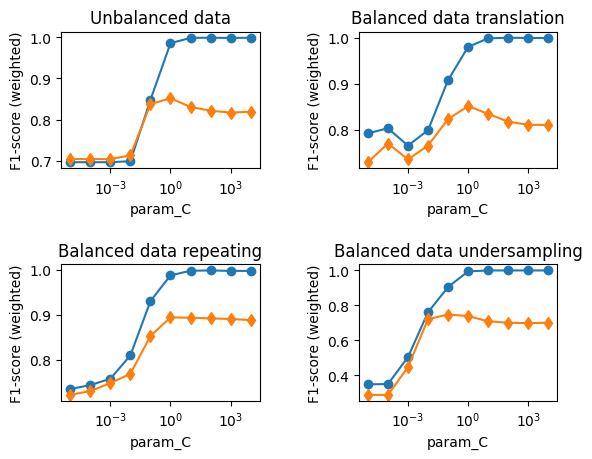

In [46]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(param_C, scores_data3_unbalanced[0], '-o', label='Train')
axs[0, 0].plot(param_C, scores_data3_unbalanced[1], '-d', label='Test')
axs[0, 0].set_title('Unbalanced data')
axs[0, 1].plot(param_C, scores_data3_balanced_translate[0], '-o', label='Train')
axs[0, 1].plot(param_C, scores_data3_balanced_translate[1], '-d', label='Test')
axs[0, 1].set_title('Balanced data translation')
axs[1, 0].plot(param_C, scores_data3_balanced_repeating[0], '-o', label='Train')
axs[1, 0].plot(param_C, scores_data3_balanced_repeating[1], '-d', label='Test')
axs[1, 0].set_title('Balanced data repeating')
axs[1, 1].plot(param_C, scores_data3_balanced_undsampl[0], '-o', label='Train')
axs[1, 1].plot(param_C, scores_data3_balanced_undsampl[1], '-d', label='Test')
axs[1, 1].set_title('Balanced data undersampling')

for ax in axs.flat:
    ax.set(xlabel='param_C', ylabel='F1-score (weighted)')
    ax.set_xscale('log')


plt.subplots_adjust(hspace=0.7, wspace = 0.5)

plt.show()

In [47]:
lsvc = LinearSVC(C=10**-2) # C chosen based on graph above

def linearsvc(X_train, X_val, y_train, y_val, preproc):
    lsvc_bow = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('classifier', lsvc),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])

    lsvc_bow.fit(X_train, y_train)
    result_val1 = lsvc_bow.predict(X_val)
    print('BOW')
    print(confusion_matrix(y_val, result_val1))
    f1_bow = f1_score(y_val, result_val1, average='weighted')
    
    lsvc_tfidf = Pipeline([
        ('bow', CountVectorizer(analyzer=preproc, ngram_range=(1,1))),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', lsvc),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])
    
    lsvc_tfidf.fit(X_train, y_train)
    result_val2 = lsvc_tfidf.predict(X_val)
    print('TF-IDF')
    print(confusion_matrix(y_val, result_val2))
    f1_tfidf = f1_score(y_val, result_val2, average='weighted')
    
    return f1_bow, f1_tfidf, lsvc_tfidf, lsvc_tfidf

In [48]:
print('UNBALANCED')
f1_val[2][0], f1_val[2][1], lsvc_bow_unb1, lsvc_tfidf_unb1 = linearsvc(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing1)
f1_test[2][0] = predict_test(X_test_unb, y_test_unb, lsvc_bow_unb1)
f1_test[2][1] = predict_test(X_test_unb, y_test_unb, lsvc_tfidf_unb1)

f1_val[5][0], f1_val[5][1], lsvc_bow_unb2, lsvc_tfidf_unb2 = linearsvc(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing2)
f1_test[5][0] = predict_test(X_test_unb, y_test_unb, lsvc_bow_unb2)
f1_test[5][1] = predict_test(X_test_unb, y_test_unb, lsvc_tfidf_unb2)

f1_val[8][0], f1_val[8][1], lsvc_bow_unb3, lsvc_tfidf_unb3 = linearsvc(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing3)
f1_test[8][0] = predict_test(X_test_unb, y_test_unb, lsvc_bow_unb3)
f1_test[8][1] = predict_test(X_test_unb, y_test_unb, lsvc_tfidf_unb3)

f1_val[11][0], f1_val[11][1], lsvc_bow_unb4, lsvc_tfidf_unb4 = linearsvc(X_train_unb, X_val_unb, y_train_unb, y_val_unb, preprocessing4)
f1_test[11][0] = predict_test(X_test_unb, y_test_unb, lsvc_bow_unb4)
f1_test[11][1] = predict_test(X_test_unb, y_test_unb, lsvc_tfidf_unb4)


print('UNDERSAMPLING')
f1_val[2][2], f1_val[2][3], lsvc_bow_und1, lsvc_tfidf_und1 = linearsvc(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing1)
f1_test[2][2] = predict_test(X_test_und, y_test_und, lsvc_bow_und1)
f1_test[2][3] = predict_test(X_test_und, y_test_und, lsvc_tfidf_und1)

f1_val[5][2], f1_val[5][3], lsvc_bow_und2, lsvc_tfidf_und2 = linearsvc(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing2)
f1_test[5][2] = predict_test(X_test_und, y_test_und, lsvc_bow_und2)
f1_test[5][3] = predict_test(X_test_und, y_test_und, lsvc_tfidf_und2)

f1_val[8][2], f1_val[8][3], lsvc_bow_und3, lsvc_tfidf_und3 = linearsvc(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing3)
f1_test[8][2] = predict_test(X_test_und, y_test_und, lsvc_bow_und3)
f1_test[8][3] = predict_test(X_test_und, y_test_und, lsvc_tfidf_und3)

f1_val[11][2], f1_val[11][3], lsvc_bow_und4, lsvc_tfidf_und4 = linearsvc(X_train_und, X_val_und, y_train_und, y_val_und, preprocessing4)
f1_test[11][2] = predict_test(X_test_und, y_test_und, lsvc_bow_und4)
f1_test[11][3] = predict_test(X_test_und, y_test_und, lsvc_tfidf_und4)


print('REPEATING')
f1_val[2][4], f1_val[2][5], lsvc_bow_rep1, lsvc_tfidf_rep1 = linearsvc(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing1)
f1_test[2][4] = predict_test(X_test_rep, y_test_rep, lsvc_bow_rep1)
f1_test[2][5] = predict_test(X_test_rep, y_test_rep, lsvc_tfidf_rep1)

f1_val[5][4], f1_val[5][5], lsvc_bow_rep2, lsvc_tfidf_rep2 = linearsvc(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing2)
f1_test[5][4] = predict_test(X_test_rep, y_test_rep, lsvc_bow_rep2)
f1_test[5][5] = predict_test(X_test_rep, y_test_rep, lsvc_tfidf_rep2)

f1_val[8][4], f1_val[8][5], lsvc_bow_rep3, lsvc_tfidf_rep3 = linearsvc(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing3)
f1_test[8][4] = predict_test(X_test_rep, y_test_rep, lsvc_bow_rep3)
f1_test[8][5] = predict_test(X_test_rep, y_test_rep, lsvc_tfidf_rep3)

f1_val[11][4], f1_val[11][5], lsvc_bow_rep4, lsvc_tfidf_rep4 = linearsvc(X_train_rep, X_val_rep, y_train_rep, y_val_rep, preprocessing4)
f1_test[11][4] = predict_test(X_test_rep, y_test_rep, lsvc_bow_rep4)
f1_test[11][5] = predict_test(X_test_rep, y_test_rep, lsvc_tfidf_rep4)

print('TRANSLATION')
f1_val[2][6], f1_val[2][7], lsvc_bow_tra1, lsvc_tfidf_tra1 = linearsvc(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing1)
f1_test[2][6] = predict_test(X_test_tra, y_test_tra, lsvc_bow_tra1)
f1_test[2][7] = predict_test(X_test_tra, y_test_tra, lsvc_tfidf_tra1)

f1_val[5][6], f1_val[5][7], lsvc_bow_tra2, lsvc_tfidf_tra2 = linearsvc(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing2)
f1_test[5][6] = predict_test(X_test_tra, y_test_tra, lsvc_bow_tra2)
f1_test[5][7] = predict_test(X_test_tra, y_test_tra, lsvc_tfidf_tra2)

f1_val[8][6], f1_val[8][7], lsvc_bow_tra3, lsvc_tfidf_tra3 = linearsvc(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing3)
f1_test[8][6] = predict_test(X_test_tra, y_test_tra, lsvc_bow_tra3)
f1_test[8][7] = predict_test(X_test_tra, y_test_tra, lsvc_tfidf_tra3)

f1_val[11][6], f1_val[11][7], lsvc_bow_tra4, lsvc_tfidf_tra4 = linearsvc(X_train_tra, X_val_tra, y_train_tra, y_val_tra, preprocessing4)
f1_test[11][6] = predict_test(X_test_tra, y_test_tra, lsvc_bow_tra4)
f1_test[11][7] = predict_test(X_test_tra, y_test_tra, lsvc_tfidf_tra4)

UNBALANCED
BOW
[[1048   17]
 [ 162  113]]
TF-IDF
[[1065    0]
 [ 272    3]]
[[1033    0]
 [ 307    1]]
[[1033    0]
 [ 307    1]]
BOW
[[1043   22]
 [ 172  103]]
TF-IDF
[[1065    0]
 [ 271    4]]
[[1033    0]
 [ 307    1]]
[[1033    0]
 [ 307    1]]
BOW
[[1043   22]
 [ 171  104]]
TF-IDF
[[1063    2]
 [ 260   15]]
[[1032    1]
 [ 294   14]]
[[1032    1]
 [ 294   14]]
BOW
[[1044   21]
 [ 171  104]]
TF-IDF
[[1065    0]
 [ 270    5]]
[[1033    0]
 [ 307    1]]
[[1033    0]
 [ 307    1]]
UNDERSAMPLING
BOW
[[246  16]
 [125 185]]
TF-IDF
[[251  11]
 [143 167]]
[[264  23]
 [145 140]]
[[264  23]
 [145 140]]
BOW
[[236  26]
 [115 195]]
TF-IDF
[[246  16]
 [142 168]]
[[263  24]
 [141 144]]
[[263  24]
 [141 144]]
BOW
[[237  25]
 [111 199]]
TF-IDF
[[243  19]
 [135 175]]
[[264  23]
 [134 151]]
[[264  23]
 [134 151]]
BOW
[[234  28]
 [111 199]]
TF-IDF
[[247  15]
 [140 170]]
[[262  25]
 [139 146]]
[[262  25]
 [139 146]]
REPEATING
BOW
[[982  74]
 [260 793]]
TF-IDF
[[987  69]
 [420 633]]
[[958  87]
 [377 687

In [53]:
f1_val

array([[0.70389735, 0.70389735, 0.71380471, 0.6987709 , 0.7340684 ,
        0.73334051, 0.72060626, 0.69259603],
       [0.85227615, 0.73073299, 0.74234415, 0.74048091, 0.84003785,
        0.82167132, 0.82536042, 0.82042397],
       [0.84676208, 0.70920578, 0.74842946, 0.72144411, 0.8403693 ,
        0.76147154, 0.80503619, 0.76039304],
       [0.70389735, 0.70389735, 0.66467369, 0.69511964, 0.74111659,
        0.77104953, 0.73365148, 0.72055609],
       [0.84781297, 0.72416034, 0.74439012, 0.73937318, 0.82823262,
        0.81870439, 0.81762329, 0.81101705],
       [0.83284073, 0.71095458, 0.75073311, 0.71532176, 0.83432908,
        0.77189846, 0.79518784, 0.76392963],
       [0.70389735, 0.70389735, 0.63984527, 0.68643831, 0.75779507,
        0.72190932, 0.73437695, 0.72466127],
       [0.82161564, 0.71269323, 0.76045592, 0.74815058, 0.8343503 ,
        0.81735628, 0.81983806, 0.81152912],
       [0.83391979, 0.72866171, 0.7598524 , 0.72418536, 0.83193859,
        0.73925111, 0.796824

In [54]:
f1_test

array([[0.67038015, 0.67038015, 0.6984268 , 0.68475347, 0.74586229,
        0.75260869, 0.68553442, 0.6863068 ],
       [0.77087171, 0.68934079, 0.744553  , 0.7544283 , 0.80667728,
        0.82826906, 0.805011  , 0.81503709],
       [0.67214925, 0.67214925, 0.69204395, 0.69204395, 0.77603789,
        0.77603789, 0.75412041, 0.75412041],
       [0.67038015, 0.67038015, 0.67157304, 0.66898507, 0.76785795,
        0.769202  , 0.71887288, 0.71701085],
       [0.76037579, 0.6808563 , 0.71914215, 0.7423906 , 0.80307137,
        0.83162988, 0.79005482, 0.81097042],
       [0.67214925, 0.67214925, 0.69870793, 0.69870793, 0.7846032 ,
        0.7846032 , 0.74637399, 0.74637399],
       [0.67038015, 0.67038015, 0.67775146, 0.67212267, 0.72974034,
        0.73580488, 0.71921169, 0.72088977],
       [0.73796583, 0.673909  , 0.74033897, 0.74316687, 0.79702152,
        0.82574041, 0.79317444, 0.81037313],
       [0.69390004, 0.69390004, 0.71457479, 0.71457479, 0.7632743 ,
        0.7632743 , 0.722551

## 6. Check the best model and use test data

Figure: F1-score for all the pipelines tested - validation data
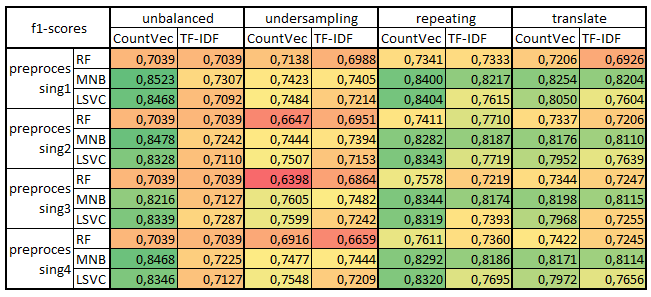

Remarks:
* Unbalanced data had the same values of f1-score in all cases, as the model got 100% right in the majority class and 0% right in the minority class
* Undersampling data had a lower f1-score


Figure: F1-score for all the pipelines tested - test data
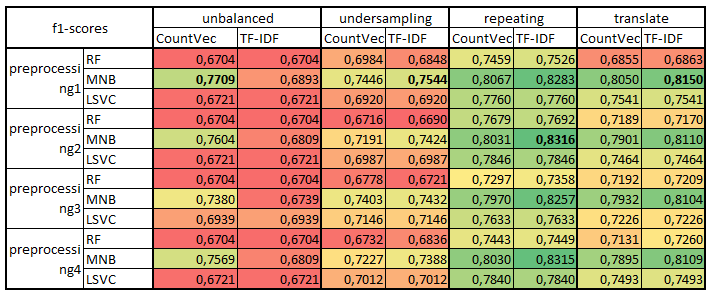


* Model created based in undersampling: can have problems with generalization, as the model was exposed to less data;
* Model created based in repeating: can be skewed;
* Model created based in translation: although f1-score is lower than "repeating", this model had access to other data, as the data of minority class was replicated with some random elements.

In [70]:
# saving the best model: mnb_tfidf_tra1

import joblib

mnb = MultinomialNB(alpha=2) # alpha chosen based on graph above
mod = Pipeline([
        ('bow', CountVectorizer(analyzer=preprocessing1, ngram_range=(1,1))),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', mnb),  # train on TF-IDF vectors w/ LinearSVC classifier
    ])

mod.fit(X_train_tra, y_train_tra)
filename = 'mnb_tfidf_tra1.sav'
joblib.dump(mod, filename)

['mnb_tfidf_tra1.sav']